![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Shakespeare with a Character-Level RNN

[In the RNN classification tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify text one character at a time. This time we'll generate text one character at a time.

```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

This one might make you question the series title &mdash; "is that really practical?" However, these sorts of generative models form the basis of machine translation, image captioning, question answering and more. See the [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) for more on that topic.

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) builds on this model to add a category as input

# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
lotr_path = '/content/gdrive/My Drive/cis530_hw6/lotr.txt'

Mounted at /content/gdrive


In [5]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O shakespeare.txt
!wget https://raw.githubusercontent.com/rdeese/tunearch-corpus/master/all-abcs.txt -O ABC_music.txt
!wget https://raw.githubusercontent.com/ryanmcdermott/trump-speeches/master/speeches.txt -O trump.txt
!wget http://www.gutenberg.org/files/31100/31100.txt -O Jane_austen.txt
!wget https://www.gutenberg.org/cache/epub/7371/pg7371.txt -O Ann_Radcliffe.txt
!pip3 install unidecode

--2021-11-02 21:45:28--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   1.06M  --.-KB/s    in 0.08s   

2021-11-02 21:45:29 (12.8 MB/s) - ‘shakespeare.txt’ saved [1115394/1115394]

--2021-11-02 21:45:29--  https://raw.githubusercontent.com/rdeese/tunearch-corpus/master/all-abcs.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7563572

In [6]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('shakespeare.txt').read())
file_len = len(file)
print('file_len =', file_len)
abc_file = unidecode.unidecode(open('ABC_music.txt').read())
abc_file_len = len(abc_file)
print('abc_file_len =', abc_file_len)
trump_file = unidecode.unidecode(open('trump.txt').read())
trump_file_len = len(trump_file)
print('trump_file_len =', trump_file_len)
ja_file = unidecode.unidecode(open('Jane_austen.txt',errors='ignore').read())
ja_file_len = len(ja_file)
print('ja_file_len =', ja_file_len)
lotr_file = unidecode.unidecode(open(lotr_path,encoding='utf-8',errors='ignore').read())
lotr_file_len = len(lotr_file)
print('lotr_file_len =', lotr_file_len)

AR_file = unidecode.unidecode(open('Ann_Radcliffe.txt',errors='ignore').read())
AR_file_len = len(AR_file)
print('AR_file_len =', AR_file_len)

file_len = 1115394
abc_file_len = 7563572
trump_file_len = 896986
ja_file_len = 4373592
lotr_file_len = 158737
AR_file_len = 418846


In [7]:
file = unidecode.unidecode(open('Jane_austen.txt',errors='ignore').read())

To make inputs out of this big string of data, we will be splitting it into chunks.

In [8]:
# chunk_len = 200

def random_chunk(f=file, chunk_len=200):
    # start_index = random.randint(0, file_len - chunk_len)
    start_index = random.randint(0, len(f) - chunk_len)
    end_index = start_index + chunk_len + 1
    return f[start_index:end_index]

print(random_chunk(lotr_file),'\n')
print(len(random_chunk(lotr_file)))


l back!       
FRODO
I can't do this, Sam.           
SAM
I know. It's all wrong.      ,By rights, we shouldn't even be here.      But we are. It's like in the great stories, Mr. Frodo. The ones that r 

201


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [9]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [10]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [11]:
def random_training_set():    
    chunk = random_chunk(file)
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target
# print(random_training_set())

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [12]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [13]:
def perplexity_score(target_seq, prime_str='A', predict_len=100, temperature=0.8):
    criterion = nn.CrossEntropyLoss()
    target = char_tensor(target_seq)
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str
    loss = 0
    for p in range(len(prime_str) - 1):
        output, hidden = decoder(prime_input[p], hidden)
        # loss += criterion(output, target[[0]])
    inp = prime_input[-1]
    # print(target)
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        loss += criterion(output, target[[p]])
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)
    return predicted, loss/predict_len
    # return predicted, loss

  

In [14]:

model_path = '/content/gdrive/My Drive/cis530_hw6/gen_model_weights_JA.pth'
n_layers = 1
hidden_size = 100
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [22]:
# cur_chunk = random_chunk(file,len(file))
import time
import numpy as np
# start = time.time()
# print(len(lotr_file))
# total = []
# for i in range(10000,len(lotr_file),10000):
#   print(i)
#   cur_chunk = lotr_file[i-10000:i]
#   pred,loss = perplexity_score(cur_chunk[1:],predict_len = len(cur_chunk)-1) # prime_str=cur_chunk[0], 
#   total.append(loss.item())
#   print(time.time()-start)
# print(np.mean(total)) # 6.638616847991943

# start = time.time()
# print(len(trump_file))
# total = []
# for i in range(10000,len(trump_file),10000):
#   print('i',i,end='')
#   cur_chunk = trump_file[i-10000:i]
#   pred,loss = perplexity_score(cur_chunk[1:],predict_len = len(cur_chunk)-1) # prime_str=cur_chunk[0], 
#   total.append(loss.item())
#   print('time',time.time()-start)
# print(np.mean(total)) # 6.233118753754691

# start = time.time()
# print(len(abc_file))
# total = []
# for i in range(100000,len(abc_file),100000):
#   print('i',i,end='')
#   cur_chunk = abc_file[i-100000:i]
#   pred,loss = perplexity_score(cur_chunk[1:],predict_len = len(cur_chunk)-1) # prime_str=cur_chunk[0], 
#   total.append(loss.item())
#   print('time',time.time()-start)
# print(np.mean(total)) # 10.061878458658855

start = time.time()
print(len(AR_file))
total = []
for i in range(100000,len(AR_file),100000):
  print('i',i,end=' ')
  cur_chunk = AR_file[i-100000:i]
  pred,loss = perplexity_score(cur_chunk[1:],predict_len = len(cur_chunk)-1) # prime_str=cur_chunk[0], 
  total.append(loss.item())
  print('loss',loss,'time',time.time()-start)
print(np.mean(total)) # 5.789788365364075


# cur_chunk = random_chunk(lotr_file)
# pred,loss = perplexity_score(cur_chunk[1:],predict_len = 200)
# print(loss)

# shakespeare train, -shake, abc, ja
# tensor(5.9889, grad_fn=<DivBackward0>)
# tensor(9.8353, grad_fn=<DivBackward0>)
# tensor(6.0052, grad_fn=<DivBackward0>)
# tensor(1228.9374, grad_fn=<AddBackward0>)
# tensor(1967.9811, grad_fn=<AddBackward0>)
# tensor(1291.7390, grad_fn=<AddBackward0>)
# JA train, -shake, abc, lotr
# tensor(5.9949, grad_fn=<DivBackward0>)
# tensor(9.3744, grad_fn=<DivBackward0>)
# tensor(5.4439, grad_fn=<DivBackward0>)

# JA train, -shake, abc, lotr - whole dataset 

418846
i 100000 loss tensor(5.6741, grad_fn=<DivBackward0>) time 48.13597226142883
i 200000 loss tensor(5.6911, grad_fn=<DivBackward0>) time 91.09358811378479
i 300000 loss tensor(5.6777, grad_fn=<DivBackward0>) time 141.44593691825867
i 400000 loss tensor(5.7051, grad_fn=<DivBackward0>) time 187.08173966407776
5.6869882345199585


In [ ]:

cur_chunk = random_chunk(file)
pred,loss = perplexity_score(cur_chunk[1:],predict_len = 200)
print(loss)

cur_chunk = random_chunk(abc_file)
pred,loss = perplexity_score(cur_chunk[1:],predict_len = 200)
print(loss)

cur_chunk = random_chunk(lotr_file)
pred,loss = perplexity_score(cur_chunk[1:],predict_len = 200)
print(loss)


tensor(1228.9374, grad_fn=<AddBackward0>)
tensor(1967.9811, grad_fn=<AddBackward0>)
tensor(1291.7390, grad_fn=<AddBackward0>)


# Training

A helper to print the amount of time passed:

In [16]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [17]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        # print(output.shape)
        # print(target[[c]].shape)
        loss += criterion(output, target[[c]])

    loss.backward()
    decoder_optimizer.step()

    # return loss.data[0] / chunk_len
    return loss.data / chunk_len

In [18]:
print(len(file))
print(len(ja_file))

4373592
4373592


Then we define the training parameters, instantiate the model, and start training:

In [21]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005
chunk_len = 200

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
    if epoch % 500 ==0:
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 18s (100 5%) 2.4854]
 31s (200 10%) 2.0967]
 44s (300 15%) 1.9905]
 57s (400 20%) 2.1110]
 10s (500 25%) 2.2645]
Wher hould a was a ferereds of his as must so him to be the am ous of dearty, was to be ageftom a loti 

 23s (600 30%) 2.0215]
 36s (700 35%) 2.1165]
 49s (800 40%) 2.0537]
 2s (900 45%) 1.6814]
 15s (1000 50%) 1.9058]
Whe to the must the imilage, able sisted be prousse
prospireled remady must ear did wold, and estaint
 

 28s (1100 55%) 2.0402]
 41s (1200 60%) 1.6797]
 54s (1300 65%) 1.6880]
 7s (1400 70%) 1.7537]
 20s (1500 75%) 1.9207]
Whe the bearsnes.

"It will be own felt without to the is was as the breat was the word frind exterted 

 34s (1600 80%) 1.8464]
 46s (1700 85%) 1.6701]
 59s (1800 90%) 2.1393]
 12s (1900 95%) 1.6844]
 25s (2000 100%) 1.6855]
When the all the coumperding has at wenles a speried, but of this
carely famen, and look they and them 



In [ ]:
# save model
import os
# torch.save(decoder.state_dict(), os.path.join('/content/gdrive/My Drive/cis530_hw6','gen_model_weights_shakespeare.pth'))
torch.save(decoder.state_dict(), os.path.join('/content/gdrive/My Drive/cis530_hw6','gen_model_weights_JA.pth'))

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

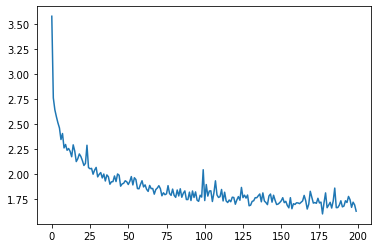

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [ ]:
print(evaluate('Th', 200, temperature=0.8))

Thick thought of chant to us of the she about the person selves not be quite ill more sis'burous me for the soon and himish. Shick sicly aw self for her was not perited whoo. He my done rease; aI left h


Lower temperatures are less varied, choosing only the more probable outputs:

In [ ]:
print(evaluate('Th', 200, temperature=0.2))

The say that some the fair that to the stand that some of the saster the some the grace the sould the death as some that that the for the say
That say the saster the part a part lieger a many shall the 


Higher temperatures more varied, choosing less probable outputs:

In [ ]:
print(evaluate('Th', 200, temperature=1.4))

Th britemaw backly meth?

COMING HAUSMIUMIBSSASTOPH I, nuwomanjs? lathins blowy, stare.
Or you; as Jeom our marng beam. who my me your will.
Hows o'm trusce ach-leanistroys
OanM Cape ear
off I liold hal


# Exercises

* Train with your own dataset, e.g.
    * Text from another author
    * Blog posts
    * Code
* Increase number of layers and network size to get better results

**Next**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)